<a href="https://colab.research.google.com/github/ykitaguchi77/GAN/blob/master/StyleGAN2_style_mixing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Style mixing (StyleGAN2)**



In [1]:
# --- githubよりコードを取得 ---
%tensorflow_version 1.x
!git clone https://github.com/cedro3/stylegan2.git
#%cd stylegan2

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 328, done.
remote: Total 328 (delta 0), reused 0 (delta 0), pack-reused 328
Receiving objects: 100% (328/328), 10.86 MiB | 7.42 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [4]:
#  --- クラスと関数の定義 ---
import numpy as np
import scipy.ndimage
import os
import PIL.Image
import sys
import bz2
from keras.utils import get_file
import dlib
import argparse
import numpy as np

%cd stylegan2
import dnnlib
import dnnlib.tflib as tflib
import re
import projector
import pretrained_networks
from training import dataset
from training import misc

# --------- ランドマーク検出 -------------
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = dlib.get_frontal_face_detector() # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = dlib.load_rgb_image(image)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [(item.x, item.y) for item in self.shape_predictor(img, detection).parts()]
            yield face_landmarks

# ---------- 顔画像の切り出し --------------            
def image_align(src_file, dst_file, face_landmarks, output_size=1024, transform_size=4096, enable_padding=True):
        # Align function from FFHQ dataset pre-processing step
        # https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py
        src_file
        dst_file 
        face_landmarks
        output_size=1024 
        transform_size=4096 
        enable_padding=True
            
        lm = np.array(face_landmarks)
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # Load in-the-wild image.
        if not os.path.isfile(src_file):
            print('\nCannot find source image. Please run "--wilds" before "--align".')
            return
        img = PIL.Image.open(src_file)

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]

        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

        # Save aligned image.
        img.save(dst_file, 'PNG')


# ------------ ファイルの解凍 ---------------        
def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


# ------------  潜在変数(ベクトル)の探索　------------
def project_real_images(num_images): 
    network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'
    dataset_name = 'dataset'  
    data_dir = 'my'  
    num_snapshots = 5

    #**Pretrained_modelをダウンロード**
    print('Loading networks from "%s"...' % network_pkl)
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    proj = projector.Projector()
    proj.set_network(Gs)

    #tfrecordからデータをダウンロード
    #train/dataset.pyを使用
    print('Loading images from "%s"...' % dataset_name)
    dataset_obj = dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False, shuffle_mb=0)
    #print(dataset_obj.shape) #[3, 1024, 1024]
    assert dataset_obj.shape == Gs.output_shape[1:]

    os.makedirs('my/real_images', exist_ok=True)  
    for image_idx in range(num_images):
        print('Projecting image %d/%d ...' % (image_idx, num_images))
        images, _labels = dataset_obj.get_minibatch_np(1)
        images = misc.adjust_dynamic_range(images, [0, 255], [-1, 1]) #train/misc.py
        
        targets=images
        png_prefix='./my/real_images/image'+str(image_idx)
        num_snapshots=num_snapshots
                
        snapshot_steps = set(proj.num_steps - np.linspace(0, proj.num_steps, num_snapshots, endpoint=False, dtype=int))
        misc.save_image_grid(targets, png_prefix + 'target.png', drange=[-1,1])
        proj.start(targets)
        while proj.get_cur_step() < proj.num_steps:
            print('\r%d / %d ... ' % (proj.get_cur_step(), proj.num_steps), end='', flush=True)
            proj.step()
            if proj.get_cur_step() in snapshot_steps:
                misc.save_image_grid(proj.get_images(), png_prefix + 'step%04d.png' % proj.get_cur_step(), drange=[-1,1])
            
            if proj.get_cur_step() == proj.num_steps:  
                vec = proj.get_dlatents() 
                if image_idx == 0:
                   vec_syn = vec
                else:
                   vec_syn = np.concatenate([vec_syn, vec])  
                print(vec_syn.shape)  
        print('\r%-30s\r' % '', end='', flush=True)

    return vec_syn

# ------------- 2つのベクトル間を補完するアニメーションの作成 -------
def generate_gif(vec_syn, idx):
    network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'  
    
    #pretrained networkをロード
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_syn_kwargs = dnnlib.EasyDict()
    Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_syn_kwargs.randomize_noise = True 
    Gs_syn_kwargs.truncation_psi = 0.5

    image_gif = []
    image_gif_256 = []
    os.makedirs('my/gif', exist_ok=True)
    for j in range(len(idx)-1):
        for i in range(40):
            vec = vec_syn[idx[j]]+(vec_syn[idx[j+1]]-vec_syn[idx[j]])*i/39
            vec = vec.reshape(1, 18, 512)
            images =  Gs.components.synthesis.run(vec, **Gs_syn_kwargs) 
            image_one = PIL.Image.fromarray(images[0], 'RGB')
            image_gif.append(image_one)
            image_gif_256.append(image_one.resize((256,256))) 

    image_gif[0].save('./my/gif/anime.gif', save_all=True, append_images=image_gif[1:],
                      duration=100, loop=0)   
    image_gif_256[0].save('./my/gif/anime_256.gif', save_all=True, append_images=image_gif_256[1:],
                      duration=100, loop=0) 

# ------------　 フォルダー内の画像を表示　--------------
import matplotlib.pyplot as plt
from PIL import Image
import glob
def display_pic(folder):
    fig = plt.figure(figsize=(30, 40))
    files = glob.glob(folder)
    files.sort()
    images=[]
    for i in range(len(files)):
        img = Image.open(files[i])    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(str(i), fontsize=20)               
    plt.show()
    plt.close()  

# ------------------ ベクトルの画像化 ---------------
def display(vec_syn):
  
    network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'  
    
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_syn_kwargs = dnnlib.EasyDict()
    Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_syn_kwargs.randomize_noise = True 
    Gs_syn_kwargs.truncation_psi = 0.5

    fig = plt.figure(figsize=(30, 40))   
    for i in range(len(vec_syn)):
        vec = vec_syn[i].reshape(1,18,512)
        image =  Gs.components.synthesis.run(vec, **Gs_syn_kwargs)        
        PIL.Image.fromarray(image[0], 'RGB')   
        ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
        image_plt = np.array(image[0])
        ax.imshow(image_plt)
        ax.set_xlabel(str(i), fontsize=20)               
    plt.show()
    plt.close()
    
    
# make dirctory
os.makedirs('my/pic', exist_ok=True)


/content/stylegan2


In [5]:
# 顔画像切り出しモデルの読み込み
LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2',
                                            LANDMARKS_MODEL_URL, cache_subdir='temp'))

64045056/64040097 [==============================] - 2s 0us/step


#**顔画像の切り出し**

sample/picに画像入れる --> my/picに保存される

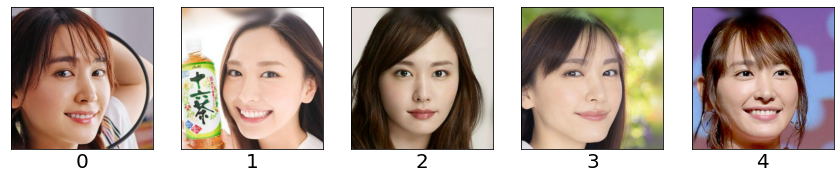

In [7]:
# 顔画像の切り出し
RAW_IMAGES_DIR = 'sample/pic'
ALIGNED_IMAGES_DIR = 'my/pic'

landmarks_detector = LandmarksDetector(landmarks_model_path)
for img_name in os.listdir(RAW_IMAGES_DIR):
    raw_img_path = os.path.join(RAW_IMAGES_DIR, img_name)
    for i, face_landmarks in enumerate(landmarks_detector.get_landmarks(raw_img_path), start=1):
        face_img_name = '%s_%02d.png' % (os.path.splitext(img_name)[0], i)
        aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
        image_align(raw_img_path, aligned_face_path, face_landmarks)
        
display_pic('./my/pic/*.*')

#**マルチプル解像度データセットの作成**

my/picフォルダーにある顔画像からマルチ解像度のデータセットを作成しmy/datasetフォルダーに保存

In [8]:
!python dataset_tool.py create_from_images ./my/dataset ./my/pic


Loading images from "./my/pic"
Creating dataset "./my/dataset"
dataset_tool.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
Added 5 images.


#**潜在変数の探索**

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Loading images from "dataset"...
[3, 1024, 1024]
Projecting image 0/5 ...
299 / 300 ... (1, 18, 512)
Projecting image 1/5 ...
299 / 300 ... (2, 18, 512)
Projecting image 2/5 ...
299 / 300 ... (3, 18, 512)
Projecting image 3/5 ...
299 / 300 ... (4, 18, 512)
Projecting image 4/5 ...
299 / 300 ... (5, 18, 512)


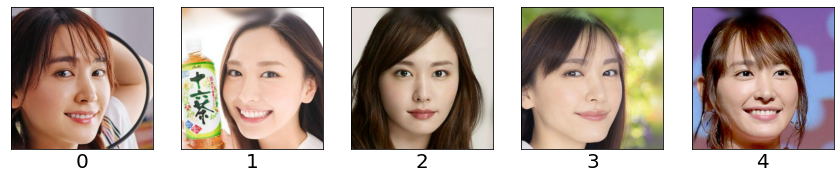

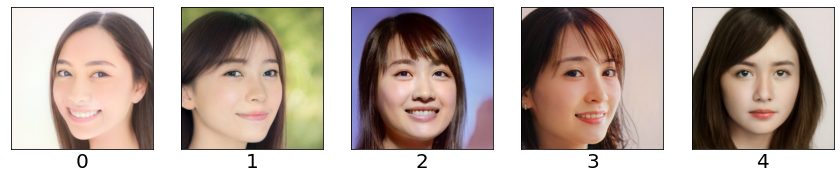

In [9]:
n_images = len(os.listdir("/content/stylegan2/my/pic"))
vec_syn = project_real_images(n_images)  # ()内はマルチ解像度のデータセットを作成した時の画像枚数
display_pic('./my/pic/*.*')  # ターゲット画像の表示
display(vec_syn)  # 探索した潜在変数によって生成した画像

In [14]:
# 探索した潜在変数の保存
os.makedirs('my/vector', exist_ok=True)
np.save('my/vector/vec_syn', vec_syn)

In [15]:
# 探索した潜在変数の読み込み
vec_syn = np.load('my/vector/vec_syn.npy')

#**顔画像のトランジション**

変数vec_synに格納されている潜在変数を元に、アニメーションを作成

作成した gifアニメーションはmy/real_gifフォルダーに保存

In [ ]:
from IPython.display import Image
generate_gif(vec_syn,[1, 0, 3])  # 潜在変数を1番目→0番目→3番目へアニメーション
Image('./my/gif/anime_256.gif', format='png')